<b>Universidad Galileo</b><br/>
<b>Maestría de Ciencia de Datos</b><br/>
<b>Statistical Learning I</b><br/>
<b>Jose Godoy</b><br/>
<b>Carnet 22000570</b><br/>
<b>30 de junio 2022</b><br/>

# 1. Sección de configuración

## 1.1 Librerías

Carga de librerías generales

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Librerías para generar métricas

In [2]:
from sklearn.metrics import accuracy_score, mean_squared_error, recall_score, f1_score
from sklearn import tree

Cargando librerías de TensorFlwo

In [36]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
tf.enable_eager_execution()

Variable de entorno TF

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Mostrar probabilidad de Bayes y regresión logística:

In [5]:
GLOBAL_MOSTRAR_PROBABILIDAD = 0;

Para cargar modelos y funciones

In [6]:
import pickle

Gráficas más grandes

In [7]:
plt.rcParams["figure.figsize"] = (16, 16)

## 1.2 Cargando datos de prueba

In [8]:
DATOS_PRUEBA = pd.read_csv("TVTS_data_prueba.csv")

# 2. Conclusiones

En el set de datos se identifico que la predicción tiene un valor de correlación alto con el sexo de la persona. A partir de esto se obtuvo una probabilidad de más del 80% de poder predecir si una persona sobrevivió o no.
<br/>
<br/>
Cada algoritmo tiene sus propias cualidades, algunos hacen un analisis simple y otros utilizan gradiente decreciente, todos se aproximaron al mismo resultado con variaciones muy pequeñas.
<br/>
<br/>
Estos son los primeros pasos que hago en predicción de datos, fue dificil identificar el limite de precisión posible con los parametros, al avanzar con cada algoritmo entendí que era la maxima presición posible con metodos convencionales.
<br/>
<br/>
El algoritmo de SVM es amplio, y también es posible utilizar k-fold con regresión logística. Con tiempo es posible obtener una presición mayor a la alcanzada.

# 3. Preprocesamiento de datos

Cargando estadísticos:

In [9]:
AE_age_mean = pickle.load(open("modelos_y_estadisticos/AE_age_mean", 'rb'))
AE_age_std = pickle.load(open("modelos_y_estadisticos/AE_age_std", 'rb'))
AE_embarked_mas_repetido = pickle.load(open("modelos_y_estadisticos/AE_embarked_mas_repetido", 'rb'))
AE_statistics = pickle.load(open("modelos_y_estadisticos/AE_statistics", 'rb'))

Función para tratar outliers

In [10]:
def AE_tratamiento_outlier(AE_dataframe, AE_columnas):
    AE_parametros_outliers = pd.DataFrame()
    for AE_columna in AE_columnas:
        AE_quartiles = np.array( AE_dataframe[AE_columna].quantile([.25, .5, .75]) )
        AE_irq = AE_quartiles[2] - AE_quartiles[0]
        AE_limite_inferior = AE_quartiles[0] - AE_irq*1.5
        AE_limite_superior = AE_quartiles[2] + AE_irq*1.5
        AE_mean_to = AE_dataframe[AE_columna].mean(axis=0)
        AE_median_to = AE_dataframe[AE_columna].median(axis=0)
        
        AE_parametros_outliers = pd.concat([
            AE_parametros_outliers, 
            pd.DataFrame(data = {
                "columna": [AE_columna],
                "limite_inferior": [AE_limite_inferior], 
                "limite_superior": [AE_limite_superior], 
                "mean": [AE_mean_to], 
                "median": [AE_median_to]
            })
        ], ignore_index=True)
        
        AE_dataframe.loc[ AE_dataframe[AE_columna] <  AE_limite_inferior, AE_columna ] = AE_mean_to
        AE_dataframe.loc[ AE_dataframe[AE_columna] >  AE_limite_superior, AE_columna ] = AE_median_to
    return AE_parametros_outliers

Función para pre procesar los datos:

In [11]:
def E_pre_procesamiento(
    E_pp_validacion, 
    E_pp_age_mean, 
    E_pp_age_std, 
    E_pp_embarked_mas_repetido, 
    E_pp_statistics, 
    E_pp_tratamiento_outlier):
    
    #Eliminación de columnas no utilizadas
    del E_pp_validacion["PassengerId"]
    del E_pp_validacion["Name"]
    del E_pp_validacion["Cabin"]
    del E_pp_validacion["Parch"]
    
    #Imputación de datos
    
    #Columna Año
    E_pp_age_nan = E_pp_validacion["Age"].isnull()
    if(len(E_pp_age_nan)>0):
        E_pp_age_random = np.random.normal(E_pp_age_mean, E_pp_age_std, sum(E_pp_age_nan))
        E_pp_validacion.loc[E_pp_age_nan, "Age"] = E_pp_age_random
    
    #Columna Ticket
    E_pp_valores_Ticket = E_pp_validacion.Ticket.value_counts().axes[0].tolist()
    E_pp_repitencia_Ticket = np.array(E_pp_validacion.Ticket.value_counts())
    E_pp_validacion['Ticket'].replace(E_pp_valores_Ticket, E_pp_repitencia_Ticket, inplace=True)
    
    #Columna Embarked
    E_pp_embarked_nan = E_pp_validacion["Embarked"].isnull()
    if(len(E_pp_embarked_nan)>0):
        E_pp_validacion.loc[E_pp_embarked_nan, "Embarked"] = E_pp_embarked_mas_repetido
    
    #Columnas categórias
    
    #Columna Embarked
    E_pp_Embarked_OHE = pd.get_dummies(E_pp_validacion.Embarked, prefix="Embarked")
    E_pp_validacion = pd.concat([E_pp_validacion, E_pp_Embarked_OHE], axis=1)
    del E_pp_validacion["Embarked"]
    
    #Columna passenger_class
    E_pp_passenger_class_OHE = pd.get_dummies(E_pp_validacion.passenger_class, prefix="passenger_class")
    E_pp_validacion = pd.concat([E_pp_validacion, E_pp_passenger_class_OHE], axis=1)
    del E_pp_validacion["passenger_class"]
    
    #Columna passenger_sex
    E_pp_sexo = E_pp_validacion["passenger_sex"] == "M"
    E_pp_validacion["passenger_sex"] = E_pp_sexo.astype('int')
    
    #Columna passenger_survived
    E_pp_sobrevivio = E_pp_validacion["passenger_survived"] == "Y"
    
    #Tratamiento de outliers
    E_pp_tratamiento_outlier(E_pp_validacion, ['Fare','SibSp', 'Age']) 
    
    #Featuring scaling
    E_pp_validacion = (E_pp_validacion.iloc[:,E_pp_validacion.columns!="passenger_survived"] - E_pp_statistics.loc["mean"]) / E_pp_statistics.loc["std"]
    E_pp_validacion["passenger_survived"] = E_pp_sobrevivio.astype('int')
    
    return E_pp_validacion

Función para separar el dataset en features y target

In [12]:
def E_separar_y_x(E_df):
    E_df_copy = E_df.copy()
    E_spyx_target = pd.DataFrame(E_df_copy["passenger_survived"])
    del E_df_copy["passenger_survived"]
    return [E_df_copy, E_spyx_target]

Pre-procesamiento y separación de información para prueba

In [13]:
#Preprocesamiento
P_data_test = E_pre_procesamiento(
    DATOS_PRUEBA, 
    AE_age_mean, 
    AE_age_std, 
    AE_embarked_mas_repetido, 
    AE_statistics, 
    AE_tratamiento_outlier
)

#Separación
P_test_features, P_test_target = E_separar_y_x( P_data_test )

# 4. Predicción

Generación de métricas

In [14]:
def E_generar_metricas(E_yhat, E_y):
    E_resultados_exp = pd.DataFrame([{
        'MSE': mean_squared_error(np.array(E_y), E_yhat),
        'Accuracy Score': accuracy_score(np.array(E_y), E_yhat),
        'Recall Score': recall_score(np.array(E_y), E_yhat),
        'F1 Score': f1_score(np.array(E_y), E_yhat)
    }])
    return E_resultados_exp

Función de predicción

In [15]:
class PredicciónResultados:
            
    def __init__(self, 
                 Model_Tree3, 
                 Model_Tree3_EAD_columnas, 
                 Model_SVM5, 
                 Model_SVM5_ESVM_columnas, 
                 ENB_Naive_Bayes_predecir,
                 Model_Bayes7_ENB_likelihood,
                 Model_Bayes7_ENB_probabilidad,
                 Model_Bayes7_ENB_columnas,
                 ERL_RegLog_predecir,
                 Model_RLog9_ERL_exp2_w, 
                 Model_RLog9_ERL_columnas
                ):
        self.Model_Tree3 = Model_Tree3 
        self.Model_Tree3_EAD_columnas = Model_Tree3_EAD_columnas 
        self.Model_SVM5 = Model_SVM5
        self.Model_SVM5_ESVM_columnas = Model_SVM5_ESVM_columnas
        self.ENB_Naive_Bayes_predecir = ENB_Naive_Bayes_predecir
        self.Model_Bayes7_ENB_likelihood = Model_Bayes7_ENB_likelihood
        self.Model_Bayes7_ENB_probabilidad = Model_Bayes7_ENB_probabilidad
        self.Model_Bayes7_ENB_columnas = Model_Bayes7_ENB_columnas
        self.ERL_RegLog_predecir = ERL_RegLog_predecir
        self.Model_RLog9_ERL_exp2_w = Model_RLog9_ERL_exp2_w
        self.Model_RLog9_ERL_columnas = Model_RLog9_ERL_columnas
        
    def Tree(self, x):
        return self.Model_Tree3.predict(x.iloc[:,self.Model_Tree3_EAD_columnas])
        
    def SVM(self, x):
        return self.Model_SVM5.predict(x.iloc[:,self.Model_SVM5_ESVM_columnas])
        
    def Bayes(self, x):
        return self.ENB_Naive_Bayes_predecir(self.Model_Bayes7_ENB_likelihood, self.Model_Bayes7_ENB_probabilidad, x, self.Model_Bayes7_ENB_columnas)
        
    def RegLog(self, x):
        return self.ERL_RegLog_predecir(x, self.Model_RLog9_ERL_exp2_w, self.Model_RLog9_ERL_columnas)
    
    def Predecir(self, x):
        predicciones = pd.DataFrame()
        predicciones["tree"] = self.Tree(x)
        predicciones["svm"] = self.SVM(x)
        predicciones["bayes"] = self.Bayes(x)
        predicciones["reglog"] = self.RegLog(x)
        return predicciones.mode(axis=1).loc[:,0]

## 4.1 Cargando modelos

### 4.1.1 Árbol de desición

In [16]:
Model_Tree3 = pickle.load(open("modelos_y_estadisticos/Model_Tree3", 'rb'))
Model_Tree3_EAD_columnas = pickle.load(open("modelos_y_estadisticos/Model_Tree3_EAD_columnas", 'rb'))

### 4.1.2 SVM

In [17]:
Model_SVM5 = pickle.load(open("modelos_y_estadisticos/Model_SVM5", 'rb'))
Model_SVM5_ESVM_columnas = pickle.load(open("modelos_y_estadisticos/Model_SVM5_ESVM_columnas", 'rb'))

### 4.1.3 Naive Bayes

Función de predicción

In [18]:
def ENB_Naive_Bayes_predecir(ENB_nbp_likelihood, ENB_nbp_probabilidad, ENB_nbp_x, ENB_nbp_columns):
    ENB_nbp_predecir = ENB_nbp_x.iloc[:,ENB_nbp_columns]
    ENB_nbp_prediccion = pd.DataFrame()
    for row in ENB_nbp_predecir.index:
        row_probabildiad0 = ENB_nbp_probabilidad[0];
        row_probabildiad1 = ENB_nbp_probabilidad[1];
        for col in ENB_nbp_predecir.columns:
            try:
                row_probabildiad0 = row_probabildiad0 * ENB_nbp_likelihood[col][0][ENB_nbp_predecir[col][row]]
                row_probabildiad1 = row_probabildiad1 * ENB_nbp_likelihood[col][1][ENB_nbp_predecir[col][row]]
            except KeyError:
                continue
        ENB_nbp_prediccion = pd.concat([ENB_nbp_prediccion, pd.DataFrame([{"N":row_probabildiad0,"Y":row_probabildiad1}])])
    arg_max = np.argmax(np.array(ENB_nbp_prediccion),axis=1)
    if( GLOBAL_MOSTRAR_PROBABILIDAD==1):
        print("Probabilidad de algoritmo de Bayes:")
        print(np.array(ENB_nbp_prediccion)[0][arg_max].round(2))
    return arg_max

Cargando modelo

In [19]:
Model_Bayes7_ENB_columnas = pickle.load(open("modelos_y_estadisticos/Model_Bayes7_ENB_columnas", 'rb'))
Model_Bayes7_ENB_likelihood = pickle.load(open("modelos_y_estadisticos/Model_Bayes7_ENB_likelihood", 'rb'))
Model_Bayes7_ENB_probabilidad = pickle.load(open("modelos_y_estadisticos/Model_Bayes7_ENB_probabilidad", 'rb'))

### 4.1.4 Regresión Logística

Función de predicción

In [20]:
def ERL_RegLog_predecir(ERL_x, ERL_w, ERL_columnas):
        ERL_x = ERL_x.iloc[:, ERL_columnas]
        ERL_x_ = np.hstack(( ERL_x, np.ones((ERL_x.shape[0],1)) ))
        ERL_yhat = tf.matmul(ERL_x_, ERL_w)
        ERL_p = tf.math.sigmoid(ERL_yhat)
        if( GLOBAL_MOSTRAR_PROBABILIDAD == 1):
            print("Probabilidad de algoritmo de Regresión Logística: ")
            prediccion_prob = np.array(pd.DataFrame(ERL_p.numpy()).round(2))
            print(prediccion_prob.reshape(1, prediccion_prob.shape[0])[0])
        return np.array(ERL_p>0.5).astype(int)

Cargando modelo

In [21]:
Model_RLog9_ERL_exp2_w = pickle.load(open("modelos_y_estadisticos/Model_RLog9_ERL_exp2_w", 'rb'))
Model_RLog9_ERL_columnas = pickle.load(open("modelos_y_estadisticos/Model_RLog9_ERL_columnas", 'rb'))

## 4.2 Creando modelo

In [22]:
modelo = PredicciónResultados(
    Model_Tree3, 
    Model_Tree3_EAD_columnas, 
    Model_SVM5, 
    Model_SVM5_ESVM_columnas, 
    ENB_Naive_Bayes_predecir,
    Model_Bayes7_ENB_likelihood,
    Model_Bayes7_ENB_probabilidad,
    Model_Bayes7_ENB_columnas,
    ERL_RegLog_predecir,
    Model_RLog9_ERL_exp2_w, 
    Model_RLog9_ERL_columnas
)

## 4.3 Árbol de desición

Predicción con árbol de desición

In [23]:
PAD_prediccion = modelo.Tree(P_test_features)

Resultados de predicción

In [24]:
E_generar_metricas(PAD_prediccion, P_test_target)

,MSE,Accuracy Score,Recall Score,F1 Score
0,0.162921,0.837079,0.650794,0.738739


### 4.3.1 Gráfica del arbol

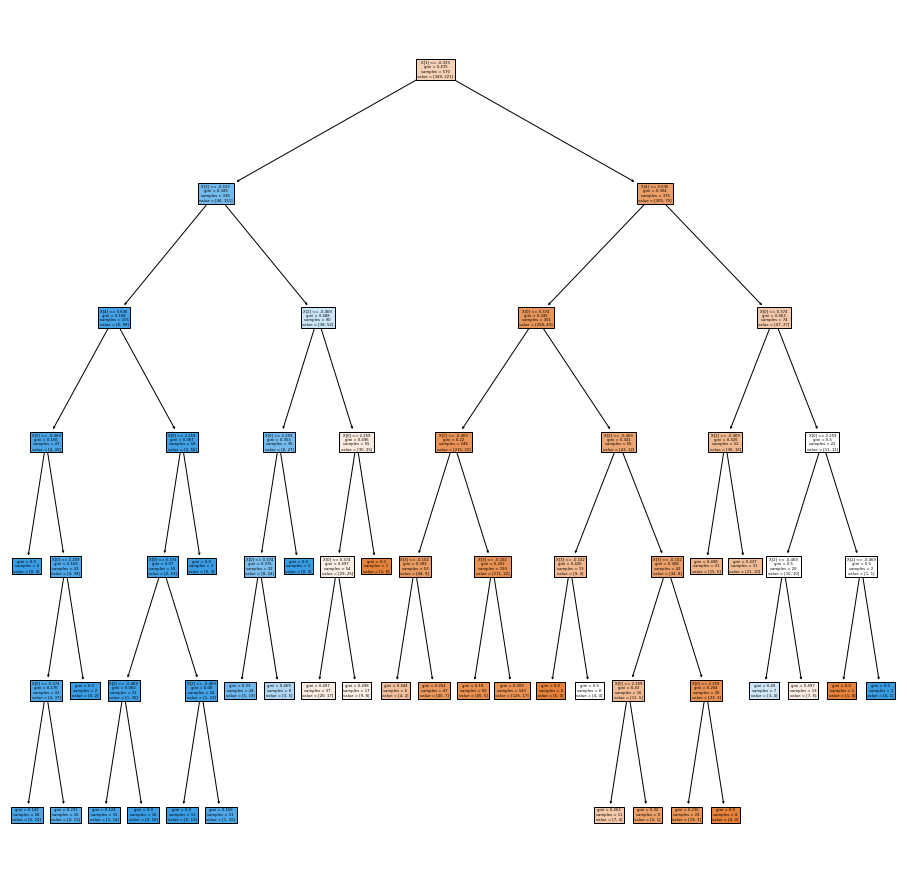

In [25]:
plt.figure()
tree.plot_tree(Model_Tree3, filled=True)
plt.savefig('tree.jpg',format='jpg',bbox_inches = "tight")

Cada nodo del árbol de decisión indica una condicional con la etiqueta X[i], en donde i es el índice del parámetro evaluado. A continuación, tiene la etiqueta gini, la cual es la probabilidad de ocurrencia. samples es la cantidad de registros evaluados.

En cada nodo evalúa su propia condición, haciendo que el árbol de decisión haga un predicción según la probabilidad registrada en el set de entrenamiento.

Ejemplo: una persona que cumpla con las siguientes características tiene una probabilidad del 0.498 de sobrevivir: SibSp menor que 0.12, fare mayor a 15.5, ticket mayor a 1, edad menor a 61, edad mayor a 34 años. En el set de datos de entrenamiento, 17 de 570 cumplieron con estas condiciones.

## 4.4 SVM

Predicción con árbol SVM

In [26]:
ESVM_prediccion = modelo.SVM(P_test_features)

Resultados de predicción

In [27]:
E_generar_metricas(ESVM_prediccion, P_test_target)

,MSE,Accuracy Score,Recall Score,F1 Score
0,0.174157,0.825843,0.619048,0.715596


## 4.5 Naive Bayes

Cargando modelo

Predicción Bayes

In [28]:
ENB_prediccion = modelo.Bayes(P_test_features)

Resultados de predicción

In [29]:
E_generar_metricas(ENB_prediccion, P_test_target)

,MSE,Accuracy Score,Recall Score,F1 Score
0,0.258427,0.741573,0.666667,0.646154


## 4.6 Regresión logística

In [30]:
ERL_prediccion = modelo.RegLog(P_test_features)

Resultados de predicción

In [31]:
E_generar_metricas(ERL_prediccion, P_test_target)

,MSE,Accuracy Score,Recall Score,F1 Score
0,0.196629,0.803371,0.666667,0.705882


# 5. Predicción final

En la predicción final se utiliza el mejor modelo de cada algoritmo y se cálcula la moda.

In [32]:
prediccion = modelo.Predecir(P_test_features)

Resultados de predicción

In [33]:
E_generar_metricas(prediccion, P_test_target)

,MSE,Accuracy Score,Recall Score,F1 Score
0,0.174157,0.825843,0.619048,0.715596


# 6. Predicción para datos aleatorios

Habilitar la opción para mostrar la predicción probabilistica de Naive Bayes y Regresión logística:

In [34]:
GLOBAL_MOSTRAR_PROBABILIDAD = 1;

Se seleccionan 10 indices aletorios y se imprime su predicción y su valor real:

In [35]:
indices_aleatorios = np.random.choice(P_test_features.shape[0], 10, replace=False)
resultado = pd.DataFrame()
resultado["prediccion"] = modelo.Predecir(P_test_features.loc[P_test_features.index.values[indices_aleatorios],:])
resultado["valor_real"] = P_test_target.passenger_survived.loc[P_test_target.passenger_survived.index.values[indices_aleatorios]].tolist()
resultado

Probabilidad de algoritmo de Bayes:
[0.54 0.12 0.12 0.12 0.54 0.12 0.54 0.54 0.54 0.12]
Probabilidad de algoritmo de Regresión Logística: 
[0.4  0.65 0.49 0.49 0.22 0.6  0.4  0.22 0.22 0.7 ]


,prediccion,valor_real
0,0,1
1,1,1
2,0,0
3,0,0
4,0,0
5,1,1
6,0,0
7,0,0
8,0,0
9,1,1
